<a href="https://colab.research.google.com/github/zezomido78/HSE-Deep-learning/blob/main/week4/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week2_honor()
# setup_google_colab.setup_week3()
setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

--2021-08-04 14:19:35--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2021-08-04 14:19:35 (61.3 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
lfw-deepfunneled.tgz
**************************************************
lfw.tgz
**************************************************
lfw_attributes.txt


In [3]:
import sys
sys.path.append("..")

import grading
import download_utils
import tqdm_utils

In [9]:
sys.path.append("/readonly/week4")
print(sys.path)


['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '..', '..', '/readonly/week4', '/readonly/week4']


In [20]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from skimage.transform import resize
import tarfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations, layers, losses, optimizers, regularizers

In [21]:
def progress(iterable, every=1):
    for index, item in enumerate(iterable):
        if index % every == 0: print("*", end="")
        yield item
    print(".")

def read_images(arch_path, crop_x=80, crop_y=80, size_x=90, size_y=90):
    with tarfile.open(arch_path) as arch:
        for entry in arch.getmembers():
            if entry.isfile() and entry.name.endswith(".jpg"):
                image = plt.imread(arch.extractfile(entry))
                image = image[crop_x : -crop_x, crop_y : -crop_y, : ]
                image = resize(image, (size_x, size_y))
                yield image

In [22]:
lfw_url = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
lfw_path = "lfw-deepfunneled.tgz"

keras.utils.get_file(lfw_path, lfw_url, cache_dir=".", cache_subdir="")

print("Extracting images: ", end="")
data = np.float32([ image for image in progress(read_images(lfw_path, size_x=36, size_y=36), every=200) ])

Extracting images: *******************************************************************.


Image shape : (36, 36, 3)
Total images: 13233


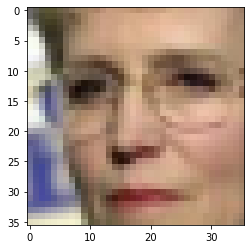

In [60]:
IMAGE_SHAPE = data.shape[1 : ]

print("Image shape :", IMAGE_SHAPE)
print("Total images:", len(data))

plt.imshow(data[ np.random.randint(len(data)) ])

In [51]:
CODE_SIZE = 256
def create_generator():
  return keras.Sequential([
                    layers.InputLayer(input_shape=(CODE_SIZE,),name="noise"),
                    layers.Dense(units= 10 * 8 * 8,activation="elu"),
                    layers.Reshape(target_shape=(8,8,10)),
                    layers.Conv2DTranspose(64,kernel_size=(5,5),strides=(1,1),activation="elu"),
                    layers.Conv2DTranspose(64,kernel_size=(5,5),strides=(1,1),activation="elu"),
                    layers.UpSampling2D(size=(2,2)),
                    layers.Conv2DTranspose(32,kernel_size=(3,3),strides=(1,1),activation="elu"),
                    layers.Conv2DTranspose(32,kernel_size=(3,3),strides=(1,1),activation="elu"),
                    layers.Conv2DTranspose(32,kernel_size=(3,3),strides=(1,1),activation="elu"),
                    layers.Conv2D(3,kernel_size=(3,3),strides=(1,1),activation=None)

  ],name="generator")
generator = create_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 640)               164480    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 12, 12, 64)        16064     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 16, 16, 64)        102464    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 34, 34, 32)        18464     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 36, 36, 32)        92

In [69]:
 def create_discriminator():
   return keras.Sequential([
                     layers.InputLayer(IMAGE_SHAPE,name="Input layer"),
                     layers.Conv2DTranspose(filters=32,kernel_size=(3,3),activation="elu"),
                     layers.Conv2D(filters=32,kernel_size=(3,3),activation='elu'),
                     layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),activation='elu'),
                     layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation="elu"),
                     layers.MaxPool2D(pool_size=(2,2)),
                     layers.Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),activation="elu"),
                     layers.Conv2D(filters=10,kernel_size=(5,5),strides=(1,1),activation="elu"),
                     layers.Flatten(),
                     layers.Dense(256,activation="tanh",kernel_regularizer=regularizers.l2()),
                     layers.Dense(1,activation="sigmoid")
   ],name="discriminator")
discriminator = create_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_6 (Conv2DTr (None, 38, 38, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 64)        102464    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 10)        

In [106]:
keras.backend.clear_session()
generator = create_generator()
discriminator = create_discriminator()
assert generator.output_shape[1 : ] == IMAGE_SHAPE, "Generator produces output shape {} instead of {}".format(generator.output_shape[1 : ], IMAGE_SHAPE)

In [107]:
noise = keras.Input(dtype=tf.dtypes.float32,shape=(CODE_SIZE))
real_data = keras.Input(dtype=tf.dtypes.float32,shape=list(IMAGE_SHAPE))

logp_real = discriminator(real_data)

generated_data = generator(noise)

logp_gen = discriminator(generated_data)

In [108]:
#From Git
def discriminator_loss(gen,disc):
  return lambda images, code  : -tf.math.reduce_mean(tf.math.log( disc(images) ) + tf.math.log( 1- disc(gen(codes)) ) )
def generator_loss(gen,disc):
  return lambda code : -tf.math.reduce_mean(    tf.math.log( disc(gen(code)) )   )

In [109]:
#Mine
def discriminator_loss(gen,disc):
  return lambda images, code  : -tf.math.reduce_mean(tf.math.log( 1-disc(images) ) + tf.math.log(  disc(gen(codes)) ) )
def generator_loss(gen,disc):
  return lambda code : -tf.math.reduce_mean(    tf.math.log(1- disc(gen(code)) )   )

In [110]:
disc_opt = optimizers.SGD(1e-3)
disc_loss = discriminator_loss(generator, discriminator)

gen_opt = optimizers.Adam(1e-4)
gen_loss = generator_loss(generator, discriminator)

In [102]:

def sample_codes(batch_size):
    return np.float32(np.random.normal(size=(batch_size, CODE_SIZE)))

def sample_images(batch_size):
    return data[ np.random.choice(len(data), size=batch_size) ]

def plot_images(nrow, ncol):
    preds = generator.predict(sample_codes(nrow * ncol))

    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(preds[i].clip(0., 1.), interpolation="none")
        plt.axis("off")
    plt.show()

def plot_probas(size):
    plt.hist(discriminator.predict(sample_images(size)),
        range=(0, 1), alpha=0.5, label="D(x)"
    )
    plt.hist(discriminator.predict(generator.predict(sample_codes(size))),
        range=(0, 1), alpha=0.5, label="D(G(x))"
    )
    plt.legend()
    plt.show()

In [112]:
epoch = tf.Variable(0)

ckpt = tf.train.Checkpoint(epoch=epoch, disc=discriminator, gen=generator, disc_opt=disc_opt, gen_opt=gen_opt)
manager = tf.train.CheckpointManager(ckpt, directory="./checkpoints", max_to_keep=10)

status = ckpt.restore(manager.latest_checkpoint)

Epoch: 6100


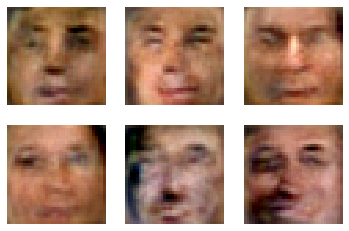

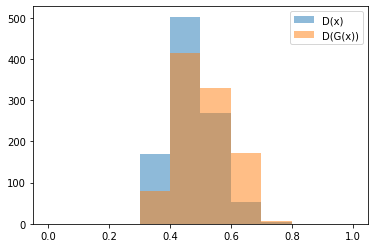

*******

In [ ]:

for _ in progress(range(20000)):
    codes = sample_codes(100)
    images = sample_images(100)

    for n in range(5):
        disc_opt.minimize(lambda: disc_loss(images, codes), discriminator.trainable_weights)

    gen_opt.minimize(lambda: gen_loss(codes), generator.trainable_weights)

    if epoch.numpy() % 100 == 0:
        display.clear_output(wait=True)

        print("Epoch:", epoch.numpy())
        plot_images(2, 3)
        plot_probas(1000)
        manager.save()

    epoch.assign_add(1)